# Exp 02: Processing time by search space.

In [1]:
# standard libraries
from time import perf_counter_ns
import time

In [12]:
# external libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns

# custom libraries
from _run_constants import *
from part_00_file_db_utils import *
from part_00_process_functions import *

# LOAD DATA

In [3]:
word_df, wg_df, letter_dict, char_matrix, \
    word_group_id_list, word_id_list, wchar_matrix = load_input_data(
        db_path=rc.DB_PATH, db_name=rc.DB_NAME,
        in_file_path=rc.IN_FILE_PATH)

...loading words into a dataframe...
...query execution took: 1.21 seconds...
...loading word groups into a dataframe...
...query execution took: 1.17 seconds...
...loading the letter dictionary...
...loading the char matrix...
...subsetting the char matrix...


In [4]:
# load the total number of anagrams
n_possible_anagrams = load_possible_anagrams(db_path=rc.DB_PATH,
                                             db_name=rc.DB_NAME)

...query execution took: 0.0 seconds...


In [5]:
# load the time df
sql = 'select * from exp_01_mod_meo_5;'
time_df = query_db(sql = sql, db_path=rc.DB_PATH, db_name = rc.DB_NAME)

...query execution took: 0.03 seconds...


In [6]:
time_df.head()

,letter_selector_id,n_search_space,total_time,letter_selector,ls_count,ls_nchar_iter,ls_nchar,avg_lookup_time,total_comps
0,0,133001,0.072118,a,2,3,1,2.711190e-07,266002
1,1,84952,0.030123,ae,1,3,2,3.545897e-07,84952
2,2,82414,0.028767,ai,1,3,2,3.490523e-07,82414
3,3,35319,0.017467,b,1,3,1,4.945525e-07,35319
4,4,23469,0.026859,ba,4,3,2,2.861136e-07,93876


In [7]:
# so, what is the relationship between total time and number of characters?
# n_search_space: the size of the letter selector
# ls_count: the number of look-ups of a search space of that size

In [8]:
# compute logs
col_names = ['n_search_space', 'total_time', 'total_comps']
for cn in col_names:
    new_cn = cn + '_log'
    time_df[new_cn] = np.log10(time_df[cn])

In [9]:
# select records that feature three characters.
# the letter selectors that are 1 and 2 characters are going to have large 
# look up sizes, but they are only queried once or twice
w_time_df = time_df.loc[time_df['ls_nchar'] == 3, :].copy()

In [10]:
w_time_df['total_time'].describe()

count    2250.000000
mean        0.063956
std         0.181277
min         0.006502
25%         0.009928
50%         0.014881
75%         0.035226
max         2.567735
Name: total_time, dtype: float64

In [11]:
w_time_df = w_time_df.rename(columns = {'n_search_space':'Search Space',
                                        'ls_count':'Number of Lookups'})

..\graphics\exp_02_total_time_by_total_comps.png


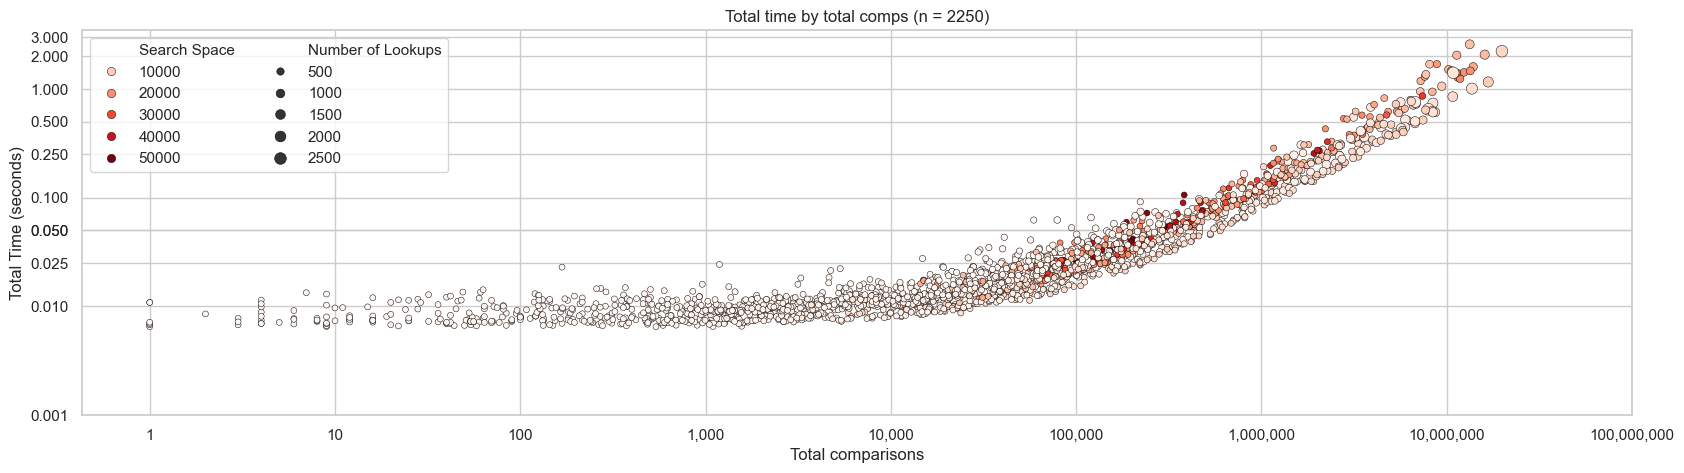

In [13]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

# define the color map

my_plot = sns.scatterplot(data=w_time_df, x="total_comps_log", y="total_time_log",
                          edgecolor = 'black', hue='Search Space',
                          marker='o', size = 'Number of Lookups', palette='Reds', alpha = 1)

y_ticks = [0.001, .05, .01, .025, .05, .1, .25, .5, 1, 2, 3]
y_ticks_log = [np.log10(yt) for yt in y_ticks]
y_tick_labels_formatted = ['{:.3f}'.format(ytl) for ytl in y_ticks]  

my_plot.set_yticks(ticks = y_ticks_log)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8]
x_ticks_log = [10 ** xt for xt in x_ticks]
x_tick_labels_formatted = ['{:,}'.format(xtl) for xtl in x_ticks_log]   

my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_labels_formatted, rotation=0)

plt.legend(loc = 'upper left', ncol = 2, title = None)
plt.title(label = f"Total time by total comps (n = {w_time_df.shape[0]})")
plt.xlabel(xlabel = 'Total comparisons')
plt.ylabel(ylabel = "Total Time (seconds)")
output_file_name = '..\\graphics\\exp_02_total_time_by_total_comps.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [ ]:
# This graphic isn't that surprising. What it shows is that as the number of total comparisons (n_search_space * number_of_lookups) increases,
# the total time increases. Which makes sense. The color is showing the size of the search space. It's not so much the number of lookups,
# rather it's the size of the search space. That's what driving the increase in the processing time. In particular, it looks like its
# search spaces GTE 30K. That could be something to optimize. So, for example, if a three letter search space has GTE 30K elements
# split it by one more letter. The issue with splitting by an additional letter increases the number of letter selectors which in 
# increases the size of another search space.
# For example: 
# the three letter selector takes about 2.5 minutes with 2,387 letter selectors.
# the four letter selector takes a little over 3.0 minutes with 10,222 letter selectors. 
# Is there some small increase in the number of letter selectors that decreases the total time taken because it decreases the number of lookups of 
# large search spaces? 

In [14]:
# what percent of the matrix is zero?
wchar_matrix.shape

(215842, 26)

In [15]:
# percent non-zero
wchar_matrix.nonzero()[0].shape[0] / wchar_matrix.size

0.29598930271644575

In [ ]:
# about 30-percent of the matrix is non-zero.